# Hurricane Emulator

In [1]:
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [11]:
from typing import Tuple, Callable
import os
import numpy as np
import matplotlib.pyplot as plt
from adcircpy.outputs import Maxele
from sithom.plot import plot_defaults, label_subplots
from sithom.time import timeit
from sithom.place import Point
from src.conversions import si_ify, knots_to_ms
from src.constants import NEW_ORLEANS, DATA_PATH, NO_BBOX
from src.models.generation import ImpactSymmetricTC, Holland08

In [15]:
@np.vectorize
def indices_in_bbox(lon, lat):
    return (
        lon > NO_BBOX.lon[0]
        and lon < NO_BBOX.lon[1]
        and lat > NO_BBOX.lat[0]
        and lat < NO_BBOX.lat[1]
    )


@timeit
def func(rmax: float, folder: str, point: Point) -> float:
    output_direc = os.path.join(folder, "a" + "{:.3f}".format(rmax) + "_kat_rmax")
    ImpactSymmetricTC(
        point=point,
        output_direc=output_direc,
        symetric_model=Holland08(rmax=rmax),
    ).run_impact()
    path = os.path.join(output_direc, "maxele.63.nc")
    maxele = Maxele(path, crs="EPSG:4326")
    index_set = 27
    indices = indices_in_bbox(maxele.x, maxele.y)
    return maxele.values[indices][index_set]


@timeit
def function_sweep() -> Tuple[np.ndarray, np.ndarray]:
    rmax_min = 1e3
    rmax_max = 1e5
    rmaxes = np.linspace(rmax_min, rmax_max, num=1)

    lon_diff = 0.6
    point = Point(NEW_ORLEANS.lon + lon_diff, NEW_ORLEANS.lat)
    folder = os.path.join(DATA_PATH, "kat_emulation3")

    if not os.path.exists(folder):
        os.mkdir(folder)

    height_list = []

    for i in range(len(rmaxes)):
        height_list.append(func(rmaxes[i], folder, point))

    return rmaxes, np.array(height_list)


print(function_sweep())

'prepare_run'  12.23466 s 

'prepare_run'  42.90725 s 

'prepare_run'  11.74334 s 

'create_inputs'  01 min 06 s 

'run_adcirc'  04 min 54 s 

'func'  06 min 01 s 

'function_sweep'  06 min 01 s 

(array([1000.]), array([0.56463788]))


In [40]:
from typing import Callable


@timeit
def func_for_emukit() -> Callable:
    lon_diff = 0.6
    point = Point(NEW_ORLEANS.lon + lon_diff, NEW_ORLEANS.lat)
    folder = os.path.join(DATA_PATH, "kat_emulation")

    if not os.path.exists(folder):
        os.mkdir(folder)
        
    def _func(rmax):
        return func(float(rmax), folder, point)
    
    return _func

In [41]:
f = func_for_emukit() 

'func_for_emukit'  0.00003 s 



In [24]:
f(1e5)

'prepare_run'  11.91292 s 

'prepare_run'  44.73838 s 

'prepare_run'  12.21178 s 

'create_inputs'  01 min 08 s 

'run_adcirc'  04 min 54 s 

'func'  06 min 03 s 



9.24378669857237

In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio as io
from frozendict import frozendict
import GPy
from GPy.models import GPRegression
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.model_wrappers import SimpleGaussianProcessModel
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.model_wrappers import GPyModelWrapper
from emukit.experimental_design.acquisitions import ModelVariance
from sithom.plot import plot_defaults, label_subplots
from sithom.misc import in_notebook
from xarray.core.utils import FrozenDict
from src.constants import DATA_PATH, FIGURE_PATH
from src.models.generation import ImpactSymmetricTC, Holland08
from emukit.core.initial_designs.latin_design import LatinDesign

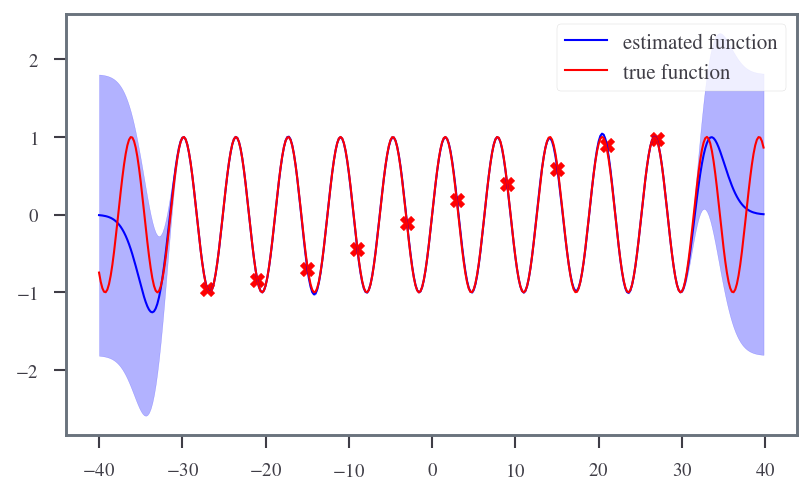

In [38]:
plot_defaults()

def example_plot() -> None:
    """
    Example plot.
    """

    plot_defaults()
    x_min = -30.0
    x_max = 30.0

    # x_data = np.random.uniform(x_min, x_max, (10, 1))
    p = ContinuousParameter("x", x_min, x_max)
    space = ParameterSpace([p])

    design = LatinDesign(space)
    num_data_points = 10
    x_data = design.get_samples(num_data_points)

    y_data = np.sin(x_data) + np.random.randn(10, 1) * 0.05
    emukit_model = SimpleGaussianProcessModel(x_data, y_data)

    loop = ExperimentalDesignLoop(space, emukit_model)
    loop.run_loop(np.sin, 30)
    plot_min = -40.0
    plot_max = 40.0
    real_x = np.arange(plot_min, plot_max, 0.2)
    real_y = np.sin(real_x)

    loop = ExperimentalDesignLoop(space, emukit_model)
    loop.run_loop(np.sin, 30)
    plot_min = -40.0
    plot_max = 40.0
    real_x = np.arange(plot_min, plot_max, 0.2)
    real_y = np.sin(real_x)
    predicted_y = []
    predicted_std = []
    for x in real_x:
        y, var = emukit_model.predict(np.array([[x]]))
        std = np.sqrt(var)
        predicted_y.append(y)
        predicted_std.append(std)

    predicted_y = np.array(predicted_y).flatten()
    predicted_std = np.array(predicted_std).flatten()
    plt.plot(real_x, predicted_y, label="estimated function", color="blue")
    plt.fill_between(
        real_x,
        predicted_y - predicted_std,
        predicted_y + predicted_std,
        color="blue",
        alpha=0.3,
    )
    plt.scatter(x_data, y_data, c="red")
    plt.plot(real_x, real_y, label="true function", color="red")
    plt.legend()

    if in_notebook():
        plt.show()
    else:
        plt.clf()

example_plot()

In [ ]:
plot_defaults()


@timeit
def example_plot() -> None:
    """
    Example plot.
    """

    plot_defaults()
    x_min = 10e3
    x_max = 10e5

    # x_data = np.random.uniform(x_min, x_max, (10, 1))
    p = ContinuousParameter("x", x_min, x_max)
    space = ParameterSpace([p])

    design = LatinDesign(space)
    num_data_points = 3
    x_data = design.get_samples(num_data_points)
    y_data = np.zeros(x_data.shape) 
    for i in range(len(x_data)):
        y_data[i] = f(x_data[i])
    
    emukit_model = SimpleGaussianProcessModel(x_data, y_data)

    loop = ExperimentalDesignLoop(space, emukit_model)
    loop.run_loop(f, 1)

    predicted_y = []
    predicted_std = []

    for x in real_x:
        y, var = emukit_model.predict(np.array([[x]]))
        std = np.sqrt(var)
        predicted_y.append(y)
        predicted_std.append(std)
        
        
    real_x = np.arange(x_min, x_max, 1)
    predicted_y = np.array(predicted_y).flatten()
    predicted_std = np.array(predicted_std).flatten()
    plt.plot(real_x, predicted_y, label="estimated function", color="blue")
    plt.fill_between(
        real_x,
        predicted_y - predicted_std,
        predicted_y + predicted_std,
        color="blue",
        alpha=0.3,
    )
    plt.scatter(x_data, y_data, c="red")
    plt.plot(real_x, real_y, label="true function", color="red")
    plt.legend()
    print(x_data, y_data)

    if in_notebook():
        plt.show()
    else:
        plt.clf()

example_plot()

'prepare_run'  9.50218 s 

'prepare_run'  33.54177 s 

'prepare_run'  9.29235 s 

'create_inputs'  52.37884 s 

'run_adcirc'  03 min 53 s 

'func'  04 min 45 s 

'prepare_run'  9.49164 s 

'prepare_run'  33.55252 s 

'prepare_run'  9.08641 s 

'create_inputs'  52.17609 s 

'run_adcirc'  03 min 51 s 

'func'  04 min 43 s 

'prepare_run'  9.61535 s 

'prepare_run'  35.27385 s 

'prepare_run'  9.23396 s 

'create_inputs'  54.16763 s 

'run_adcirc'  03 min 50 s 

'func'  04 min 44 s 

'prepare_run'  9.56592 s 

'prepare_run'  34.21038 s 

'prepare_run'  9.39325 s 

'create_inputs'  53.21307 s 



In [29]:
y_data = np.zeros((2, 3))

In [32]:
y_data.shape

(2, 3)